# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

1.   Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ
2.   Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения


In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GRU, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

# Временные ряды

In [2]:
df = pd.read_csv('airline-passengers.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.index = df.Month
df.drop(['Month'],axis = 1,inplace = True)

In [6]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Посмотрим, как выглядят наши данные:

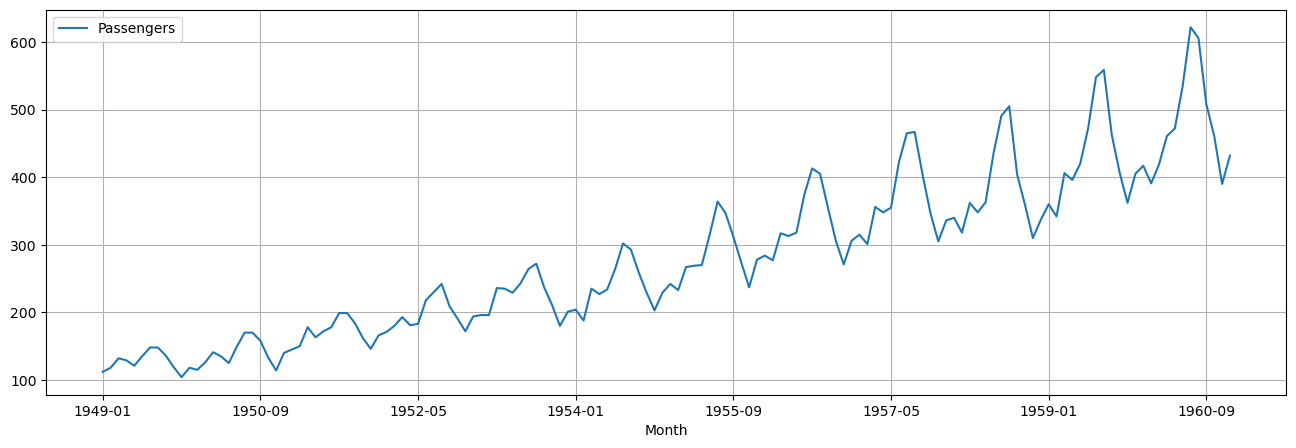

In [7]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

Добавим новые фичи - месяц и год:

In [8]:
df['month'] = pd.to_datetime(df.index).month/12.0
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()

,Passengers,month,year
Month,,,
1949-01,112,0.083333,0
1949-02,118,0.166667,0
1949-03,132,0.250000,0
1949-04,129,0.333333,0
1949-05,121,0.416667,0


In [9]:
df.shape

(144, 3)

На тест возьмем последние 100 измерений:

In [10]:
train_size = 100
train, test = df.iloc[0:train_size,:], df.iloc[train_size:,:]

Так как последовательность у нас возрастающая, проведем нормализацию MinMaxScaler не от 0 до 1, а в меньшем интервале:

In [11]:
scaler = MinMaxScaler(feature_range=(0, .55))
train = scaler.fit_transform(train)
test = scaler.transform(test)

Функция для формирования датасета:

In [12]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

В нашей последовательности заметна явная периодичность с периодом в год. Поэтому для работы рекуррентой сети возьмем глубину в 12 значений:

In [13]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Составим словарь с метриками для различной ширины рекуррентного слоя:

In [14]:
metrics = {'train_mae': [], 'val_mae': []}
for i in [8, 16, 32, 64, 128, 256]:
  callbaсk = EarlyStopping(monitor = 'val_mae', patience=5)

  model = Sequential()
  model.add(LSTM(i, input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = "True"))
  model.add(Flatten())                          
  model.add(Dense(12, activation="linear"))      

  model.add(Dense(1, activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

  history = model.fit(
      trainX, trainY,
      batch_size = 34,
      epochs = 100,
      validation_data = [testX, testY],
      callbacks = [callbaсk],
      verbose=0)
  
  metrics['train_mae'].append(history.history['mae'][-1])
  metrics['val_mae'].append(history.history['val_mae'][-1])
  print(f'validate RNN with {i} LSTM')

metrics = pd.DataFrame(metrics, index=['8 LSTM', '16 LSTM', '32 LSTM', '64 LSTM', '128 LSTM', '256 LSTM'])

validate RNN with 8 LSTM
validate RNN with 16 LSTM
validate RNN with 32 LSTM
validate RNN with 64 LSTM
validate RNN with 128 LSTM
validate RNN with 256 LSTM


In [15]:
metrics

,train_mae,val_mae
8 LSTM,0.076520,0.204340
16 LSTM,0.044052,0.102764
32 LSTM,0.017971,0.046623
64 LSTM,0.017452,0.039073
128 LSTM,0.016477,0.037535
256 LSTM,0.015669,0.032583


Наилучший результат достигается при 256 нейронах LSTM

Теперь подберем оптимальное количество нейронов плотного слоя:

In [16]:
metrics2 = {'train_mae': [], 'val_mae': []}
for i in range(8, 17):
  callbaсk = EarlyStopping(monitor = 'val_mae', patience=5)

  model = Sequential()
  model.add(LSTM(128, input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = "True"))
  model.add(Flatten())                          
  model.add(Dense(i, activation="linear"))      

  model.add(Dense(1, activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

  history = model.fit(
      trainX, trainY,
      batch_size = 34,
      epochs = 100,
      validation_data = [testX, testY],
      callbacks = [callbaсk],
      verbose=0)
  
  metrics2['train_mae'].append(history.history['mae'][-1])
  metrics2['val_mae'].append(history.history['val_mae'][-1])
  print(f'validate RNN with {i} Dense')

metrics2 = pd.DataFrame(metrics2, index=np.arange(8, 17))
metrics2

validate RNN with 8 Dense
validate RNN with 9 Dense
validate RNN with 10 Dense
validate RNN with 11 Dense
validate RNN with 12 Dense
validate RNN with 13 Dense
validate RNN with 14 Dense
validate RNN with 15 Dense
validate RNN with 16 Dense


,train_mae,val_mae
8,0.016318,0.038755
9,0.016335,0.035584
10,0.056046,0.094832
11,0.015969,0.036322
12,0.015386,0.035771
13,0.016692,0.036999
14,0.025153,0.062883
15,0.015471,0.035891
16,0.016929,0.040979


Лучшие показатели у модели с 12 нейронами плотного слоя

Обучим итоговую модель:

In [17]:
callbaсk = EarlyStopping(monitor = 'val_mae', patience=5)

model = Sequential()
model.add(LSTM(256, input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences = "True"))
model.add(Flatten())                          
model.add(Dense(12, activation="linear"))      

model.add(Dense(1, activation="linear"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

history = model.fit(
    trainX, trainY,
    batch_size = 34,
    epochs = 100,
    validation_data = [testX, testY],
    callbacks = [callbaсk])

Epoch 1/100
3/3 [==============================] - 10s 1s/step - loss: 0.0402 - mae: 0.1511 - val_loss: 0.0427 - val_mae: 0.1838
Epoch 2/100
3/3 [==============================] - 1s 384ms/step - loss: 0.0148 - mae: 0.1031 - val_loss: 0.0460 - val_mae: 0.1734
Epoch 3/100
3/3 [==============================] - 1s 444ms/step - loss: 0.0089 - mae: 0.0731 - val_loss: 0.0496 - val_mae: 0.1850
Epoch 4/100
3/3 [==============================] - 1s 485ms/step - loss: 0.0055 - mae: 0.0563 - val_loss: 0.0140 - val_mae: 0.0922
Epoch 5/100
3/3 [==============================] - 1s 381ms/step - loss: 0.0029 - mae: 0.0427 - val_loss: 0.0159 - val_mae: 0.1129
Epoch 6/100
3/3 [==============================] - 1s 384ms/step - loss: 0.0045 - mae: 0.0547 - val_loss: 0.0113 - val_mae: 0.0815
Epoch 7/100
3/3 [==============================] - 1s 377ms/step - loss: 0.0018 - mae: 0.0317 - val_loss: 0.0207 - val_mae: 0.1084
Epoch 8/100
3/3 [==============================] - 1s 371ms/step - loss: 0.0026 - mae

Epoch 62/100
3/3 [==============================] - 1s 444ms/step - loss: 5.0895e-04 - mae: 0.0181 - val_loss: 0.0031 - val_mae: 0.0430
Epoch 63/100
3/3 [==============================] - 1s 352ms/step - loss: 5.0278e-04 - mae: 0.0180 - val_loss: 0.0030 - val_mae: 0.0427
Epoch 64/100
3/3 [==============================] - 1s 340ms/step - loss: 5.0525e-04 - mae: 0.0180 - val_loss: 0.0030 - val_mae: 0.0423
Epoch 65/100
3/3 [==============================] - 1s 340ms/step - loss: 4.9792e-04 - mae: 0.0178 - val_loss: 0.0030 - val_mae: 0.0428
Epoch 66/100
3/3 [==============================] - 1s 354ms/step - loss: 5.0380e-04 - mae: 0.0181 - val_loss: 0.0028 - val_mae: 0.0414
Epoch 67/100
3/3 [==============================] - 1s 346ms/step - loss: 4.8334e-04 - mae: 0.0177 - val_loss: 0.0028 - val_mae: 0.0413
Epoch 68/100
3/3 [==============================] - 1s 377ms/step - loss: 4.8476e-04 - mae: 0.0177 - val_loss: 0.0027 - val_mae: 0.0407
Epoch 69/100
3/3 [==============================

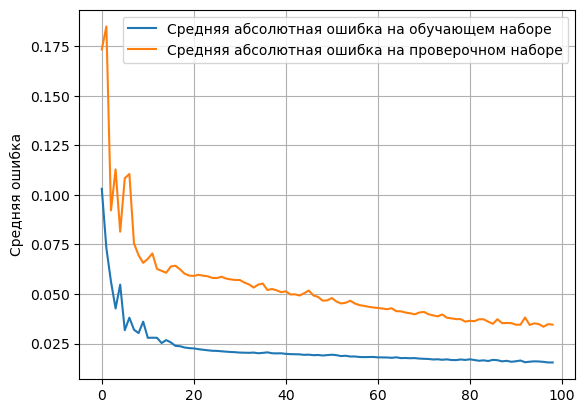

In [18]:
def plot_errors(history):
  plt.plot(history.history['mae'][1:], 
          label = 'Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_mae'][1:], 
          label = 'Средняя абсолютная ошибка на проверочном наборе')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.grid()
  plt.show()

plot_errors(history)

Epoch 1/100
3/3 [==============================] - 1s 424ms/step - loss: 3.5815e-04 - mae: 0.0155 - val_loss: 0.0017 - val_mae: 0.0346
Epoch 2/100
3/3 [==============================] - 1s 372ms/step - loss: 3.5659e-04 - mae: 0.0155 - val_loss: 0.0017 - val_mae: 0.0340
Epoch 3/100
3/3 [==============================] - 1s 403ms/step - loss: 3.7836e-04 - mae: 0.0157 - val_loss: 0.0017 - val_mae: 0.0343
Epoch 4/100
3/3 [==============================] - 1s 364ms/step - loss: 3.5614e-04 - mae: 0.0153 - val_loss: 0.0017 - val_mae: 0.0343
Epoch 5/100
3/3 [==============================] - 1s 371ms/step - loss: 3.5065e-04 - mae: 0.0152 - val_loss: 0.0017 - val_mae: 0.0337
Epoch 6/100
3/3 [==============================] - 1s 451ms/step - loss: 3.4470e-04 - mae: 0.0152 - val_loss: 0.0017 - val_mae: 0.0349
Epoch 7/100
3/3 [==============================] - 2s 556ms/step - loss: 3.6441e-04 - mae: 0.0155 - val_loss: 0.0016 - val_mae: 0.0330
Epoch 8/100
3/3 [==============================] - 1s 3

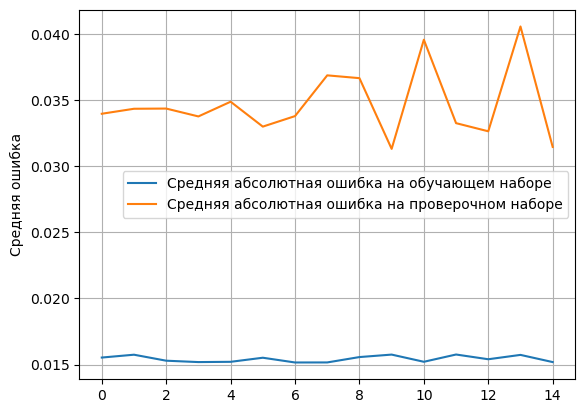

In [19]:
history = model.fit(
    trainX, trainY,
    batch_size = 34,
    epochs = 100,
    validation_data = [testX, testY],
    callbacks = [callbaсk])

plot_errors(history)

Визуализируем предсказания на трейне и тесте:

3/3 [==============================] - 2s 146ms/step


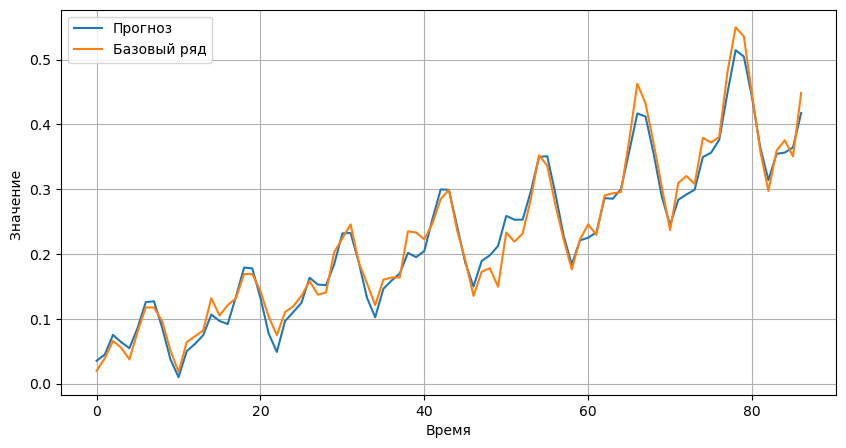

1/1 [==============================] - 0s 185ms/step


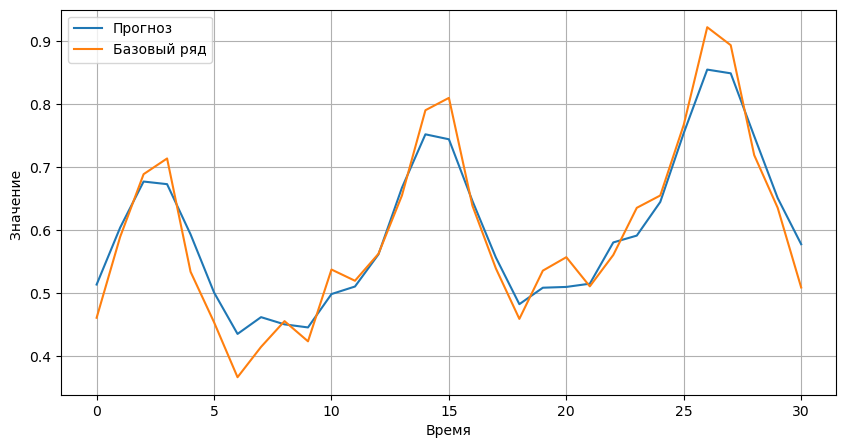

In [20]:
def plot_predict(model, X, Y):
  pred = model.predict(X).flatten()
  plt.figure(figsize=(10,5))
  plt.grid('on')
  plt.plot(pred, 
          label = 'Прогноз')
  plt.plot(Y.flatten(), 
          label = 'Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение ')

  plt.legend()
  plt.show()

plot_predict(model, trainX, trainY)
plot_predict(model, testX, testY)

Нейросеть довольно неплохо справляется с предсказанием временного ряда.

Посмотрим лаговую корелляцию предсказанного ряда с исходным:

In [21]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

3/3 [==============================] - 1s 147ms/step


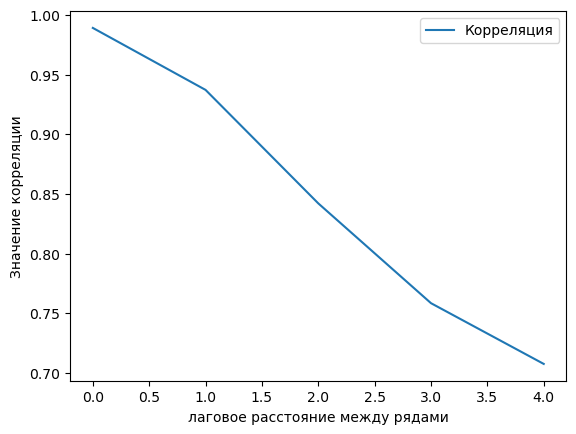

1/1 [==============================] - 0s 176ms/step


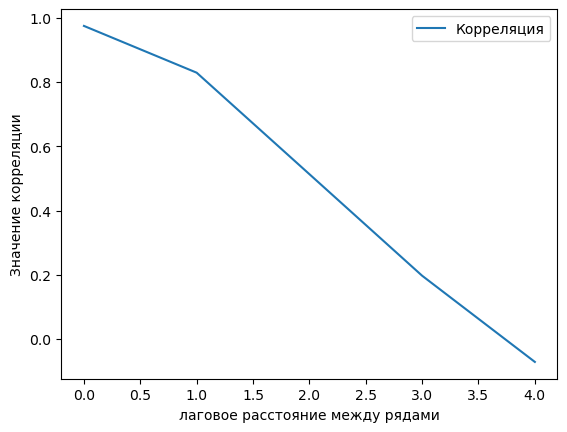

In [22]:
def plot_lag_cor(model, X, Y):
  corr = []
  yLen = Y.shape[0]
  yValF = Y.flatten() # ряд истиных значений
  yPredVal = model.predict(X).flatten() # ряд предсказаний 
  # смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
  for i in range(5):
    corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
    
  plt.plot(corr, 
          label = 'Корреляция')
  plt.xlabel('лаговое расстояние между рядами')
  plt.ylabel('Значение корреляции')
  plt.legend()
  plt.show()

plot_lag_cor(model, trainX, trainY)
plot_lag_cor(model, testX, testY)

Максимум лаговой корелляции в нуле - отличный результат!

# Генерация текста

Загрузим текст:

In [23]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(   num_words=10000)
data = open('alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [24]:
corpus[100:110]

['longitude either, but thought they were nice grand words to say.)',
 '',
 'presently she began again. ‘i wonder if i shall fall right through the',
 'earth! how funny it’ll seem to come out among the people that walk with',
 'their heads downward! the antipathies, i think--’ (she was rather glad',
 'there was no one listening, this time, as it didn’t sound at all the',
 'right word) ‘--but i shall have to ask them what the name of the country',
 'is, you know. please, ma’am, is this new zealand or australia?’ (and',
 'she tried to curtsey as she spoke--fancy curtseying as you’re falling',
 'through the air! do you think you could manage it?) ‘and what an']

Уберем пустые строки:

In [25]:
corpus = [line for line in corpus if line != '']
corpus[100:110]

['herself in a long, low hall, which was lit up by a row of lamps hanging',
 'from the roof.',
 'there were doors all round the hall, but they were all locked; and when',
 'alice had been all the way down one side and up the other, trying every',
 'door, she walked sadly down the middle, wondering how she was ever to',
 'get out again.',
 'suddenly she came upon a little three-legged table, all made of solid',
 'glass; there was nothing on it except a tiny golden key, and alice’s',
 'first thought was that it might belong to one of the doors of the hall;',
 'but, alas! either the locks were too large, or the key was too small,']

Соберем датасет:

In [26]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [27]:
label.shape

(28231, 3399)

In [28]:
predictors.shape

(28231, 17)

In [29]:
def fit_text_gen(cell='LSTM'):
  callback = EarlyStopping( monitor = 'val_accuracy', patience = 5) # создаем обратный вызов - calback - тут "Ранний останов"

  model = Sequential()
  model.add(Embedding(total_words, 256, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
  # на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
  if cell == 'LSTM':
    model.add(LSTM(128))
  elif cell == 'GRU':
    model.add(GRU(128))
  else:
    model.add(SimpleRNN(128))
  model.add(Dropout( 0.1))
  model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  model.add(Dense(total_words, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  history = model.fit(predictors, label, epochs=20, validation_split=0.2, callbacks=[callback],verbose=1, batch_size=500)
  
  return model, history

Обучим модели с разными видами нейронов:

In [30]:
text_models = []
for cell in ['LSTM', 'GRU', 'SimpleRNN']:
  text_model = fit_text_gen(cell)
  text_models.append(text_model)
  print(cell)

Epoch 1/20
46/46 [==============================] - 444s 9s/step - loss: 7.7148 - accuracy: 0.0507 - val_loss: 7.3953 - val_accuracy: 0.0719
Epoch 2/20
46/46 [==============================] - 415s 9s/step - loss: 6.1938 - accuracy: 0.0553 - val_loss: 7.2395 - val_accuracy: 0.0719
Epoch 3/20
46/46 [==============================] - 409s 9s/step - loss: 5.9614 - accuracy: 0.0553 - val_loss: 7.1952 - val_accuracy: 0.0719
Epoch 4/20
46/46 [==============================] - 406s 9s/step - loss: 5.8945 - accuracy: 0.0544 - val_loss: 7.2808 - val_accuracy: 0.0719
Epoch 5/20
46/46 [==============================] - 406s 9s/step - loss: 5.8024 - accuracy: 0.0584 - val_loss: 7.2854 - val_accuracy: 0.0632
Epoch 6/20
46/46 [==============================] - 408s 9s/step - loss: 5.6929 - accuracy: 0.0623 - val_loss: 7.4463 - val_accuracy: 0.0661
LSTM
Epoch 1/20
46/46 [==============================] - 379s 8s/step - loss: 7.8158 - accuracy: 0.0536 - val_loss: 7.4403 - val_accuracy: 0.0719
Epoch 2/

In [31]:
def plot_errors(text_models):
  for _, history in text_models:
    acc = history.history['accuracy']
    acc_v = history.history['val_accuracy']
    loss = history.history['loss']
    loss_v = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(15,4))

    plt.subplot(121)
    plt.plot(epochs, acc, 'b', label='Train')
    plt.plot(epochs, acc_v, 'r', label='Test')
    plt.legend()
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.grid()
    # plt.figure()

    plt.subplot(122)
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, loss_v, 'r', label='Test')
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    
    plt.show()

In [32]:
def text_gen(text_models, string_list, next_words=10):
  words_prob = []
  for model, _ in text_models:
    for string in string_list:
      # начальная строка
      seed_text = string
      next_words = next_words
      # строим последовательность + новое предсказание  
      for _ in range(next_words):
        # текущая последовательность (токенизация и дополнение)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
        # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
        predicted = model.predict(token_list, verbose=0)
        y_predict = predicted * np.random.random(size = (1,predicted.shape[1]))
        predict_ = np.argmax(y_predict)
        output_word = ""
        # добавим новое слово в последовательность
        for word, index in tokenizer.word_index.items():
          if index == predict_:
            output_word = word
            break
        seed_text += " " + output_word
      print(seed_text)
    print()
    plt.figure(figsize=(16,4))
    plt.plot(predicted[0,:])
    plt.xlabel('номер слова')
    plt.ylabel('вероятность слова')
    plt.title('вероятности по словам')
    plt.grid('on')
    plt.show()

Посмотрим на ошибки моделей:

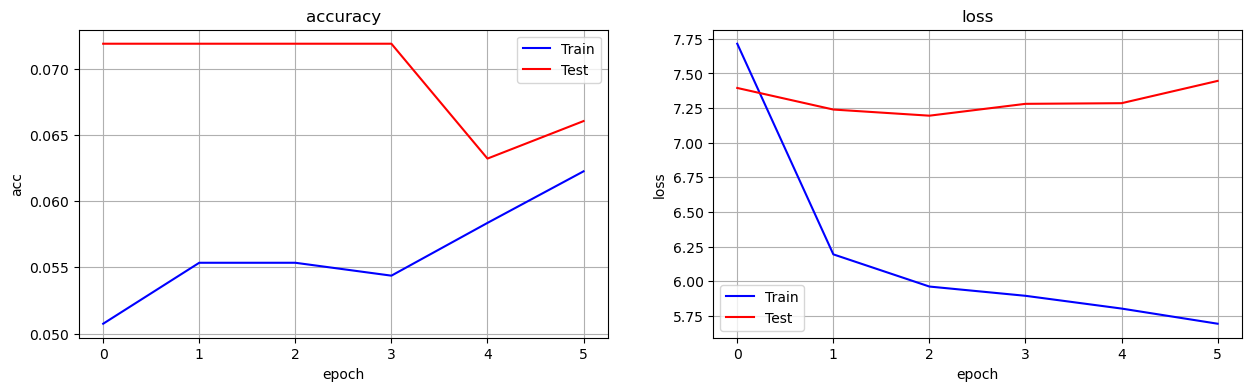

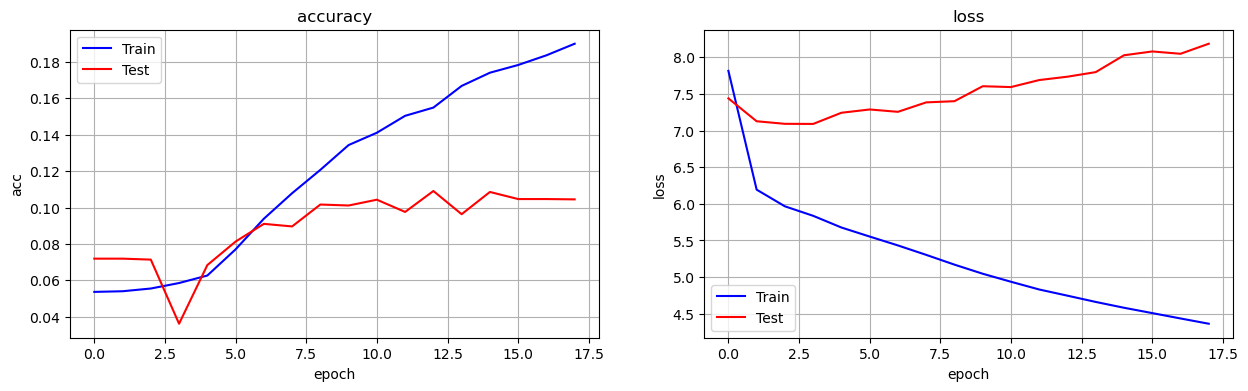

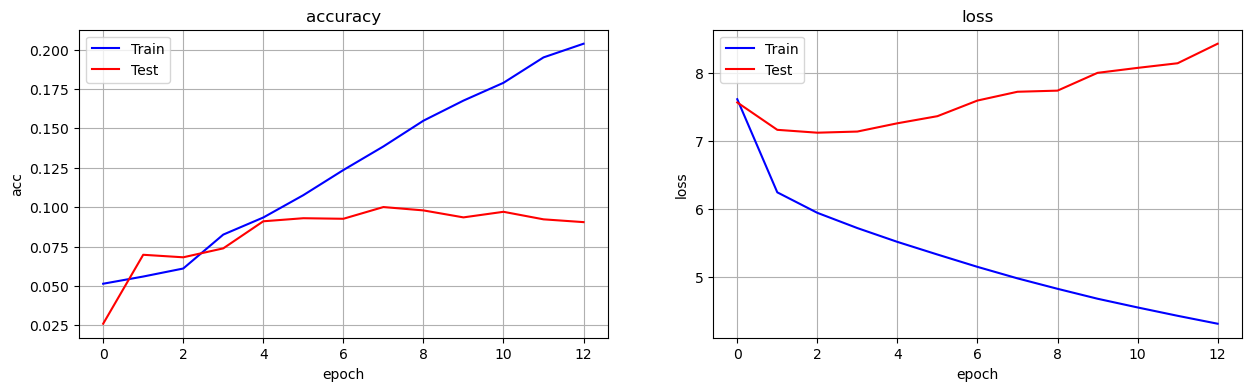

In [33]:
plot_errors(text_models)

Продолжим текст каждой моделью, а также посмотрим возможные скоры для последней позиции:

what is your name? the queen ’ the little little gryphon the queen the
hello, world the little mock was of ’ ’ the gryphon ’
white rabbit, what do you thing about me? the duchess ’ the queen and the gryphon ’ to
this flower is so the little queen ’ to the gryphon the little little



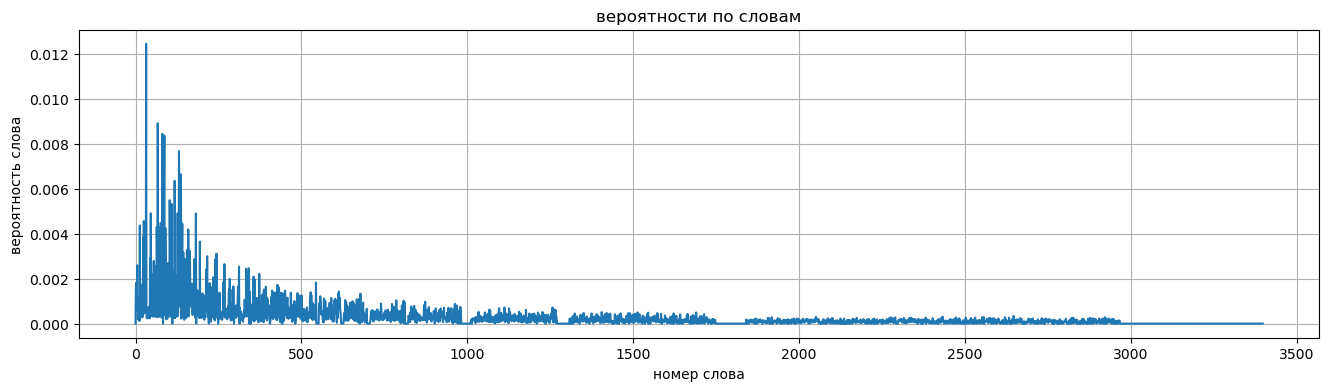

what is your name? ’ said alice in the mock turtle said to herself
hello, world you know ’ said alice in a little tone of
white rabbit, what do you thing about me? ’ said the gryphon and the rabbit went on the
this flower is so the queen was a little thing ’ said alice ‘and



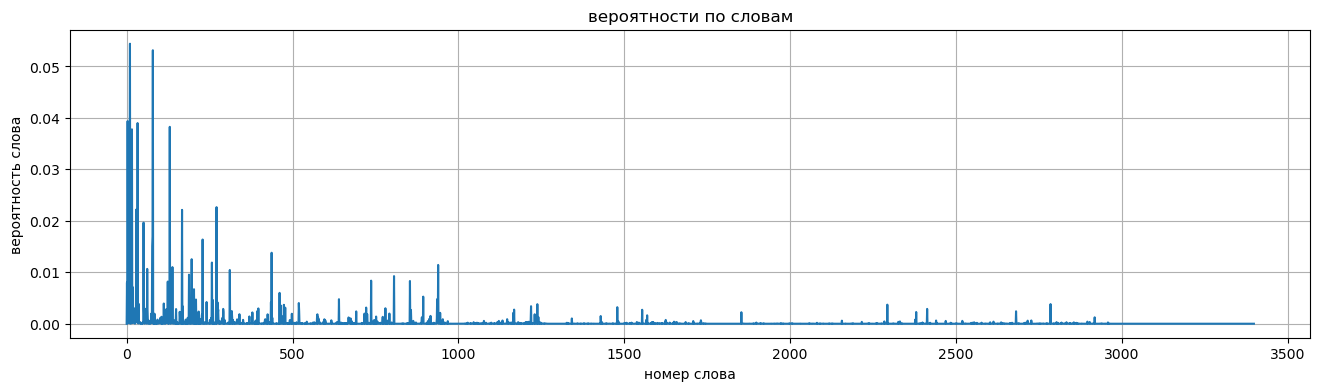

what is your name? of the same of the right were a little voice
hello, world the queen and was a little voice round the duchess
white rabbit, what do you thing about me? ’ said the mock turtle said the mock turtle and
this flower is so the other voice but the queen and had been down



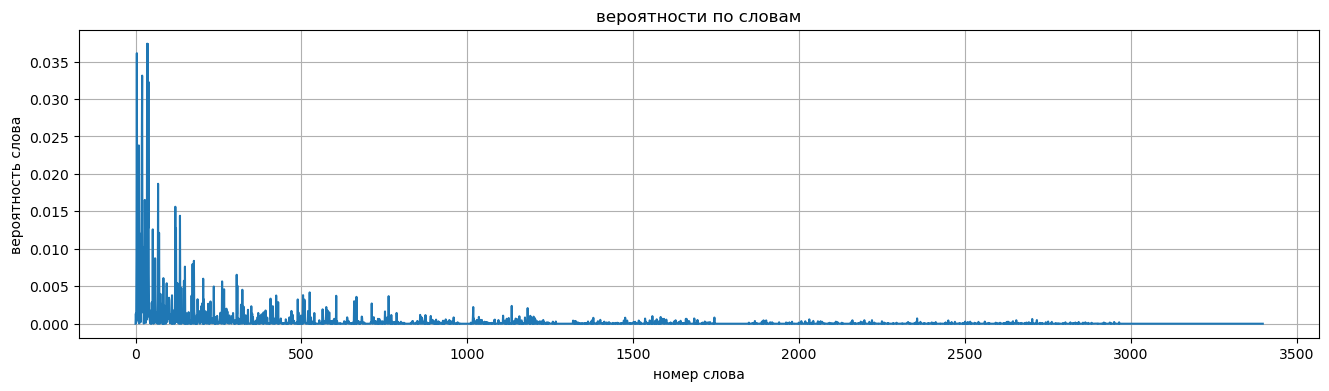

In [34]:
string_list = [
               'what is your name?',
               'hello, world',
               'white rabbit, what do you thing about me?',
               'this flower is so'
]
text_gen(text_models, string_list)

## Выводы по генерации текста:



*   Лучший текст, на мой взгляд, получается у GRU
*   Попытки подкрутить параметры моделей не увенчались успехом - во-первых, получить accuracy на тесте больше 10-11% не удавалось, во-вторых, чем выше был
accuracy, тем больше модель начинала зацикливаться на одних и тех же словах.
*   Вообще видно, что все модели используют для генерации довольно ограниченный круг слов и фраз, которые наиболее употребимы в тексте. Это видно на диаграмме вероятности по словам - наибольшая вероятность у всех слов слева.
*   Эта диаграмма дает представление о успешности генерации текста моделью. Чем меньшая дисперсия предсказаний у модели будет, тем больше она будет зацикливаться на словах. Получается парадоксальная ситуация - чем больше модель уверена в предсказанном слове, тем хуже она генерирует текст. И у GRU, как раз, наибольший разброс вероятности по словам.


